**Using Copernicus Marine Toolbox**
- Dataset Info: cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D
- Time Range: 4th September 1997 - 22nd September 2025
- Processing Level: Level 3
- Sensor: Harmonized Multisensor

In [17]:
import copernicusmarine
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [18]:
chl_data = xr.open_mfdataset('C:\\Users\\ADMIN\\marine\\monsoon\\data\\*.nc', combine='by_coords')

In [19]:
chl_data['CHL']

<xarray.DataArray 'CHL' (time: 10246, latitude: 144, longitude: 240)> Size: 1GB
dask.array<concatenate, shape=(10246, 144, 240), dtype=float32, chunksize=(366, 144, 240), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 576B -5.979 -5.938 -5.896 ... -0.0625 -0.02084
  * longitude  (longitude) float32 960B 38.02 38.06 38.1 ... 47.9 47.94 47.98
  * time       (time) datetime64[ns] 82kB 1997-09-05 1997-09-06 ... 2025-09-23
Attributes:
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water
    valid_min:      0.0
    long_name:      Chlorophyll-a concentration - Mean of the binned pixels
    valid_max:      1000.0
    units:          milligram m-3

In [20]:
season_dict = {
    'north east monsoon': [1, 2, 12],
    'south east monsoon': [6, 7, 8],
    'long rains': [3, 4, 5],
    'short rains': [9, 10, 11]
}

In [21]:
def filter_by_szn(dataset:xr.Dataset, seasons_info:dict, season:str):
    filtered_ds = dataset.isel(time=dataset.time.dt.month.isin(seasons_info[season]))
    print(f"data filtered to {season} season")
    return filtered_ds

In [22]:
def composite_season(filtered_data:xr.Dataset, dimension:str):
    seasonal_composite = filtered_data.mean(dim=dimension)
    return seasonal_composite

In [23]:
def get_szn_timeseries(filtered_data:xr.Dataset, dimensions:list):
    daily_average = filtered_data.mean(dimensions)
    yearly_average = daily_average.groupby(daily_average.time.dt.year).mean()
    return yearly_average

In [24]:
##def get_monthly_averages(filtered_data:xr.Dataset, )

In [25]:
nem = filter_by_szn(dataset=chl_data, seasons_info=season_dict, season='north east monsoon')
nem['CHL']

data filtered to north east monsoon season


<xarray.DataArray 'CHL' (time: 2527, latitude: 144, longitude: 240)> Size: 349MB
dask.array<getitem, shape=(2527, 144, 240), dtype=float32, chunksize=(353, 144, 240), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 576B -5.979 -5.938 -5.896 ... -0.0625 -0.02084
  * longitude  (longitude) float32 960B 38.02 38.06 38.1 ... 47.9 47.94 47.98
  * time       (time) datetime64[ns] 20kB 1997-12-01 1997-12-02 ... 2025-02-28
Attributes:
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water
    valid_min:      0.0
    long_name:      Chlorophyll-a concentration - Mean of the binned pixels
    valid_max:      1000.0
    units:          milligram m-3

In [26]:
nem_composite = composite_season(filtered_data=nem, dimension='time')

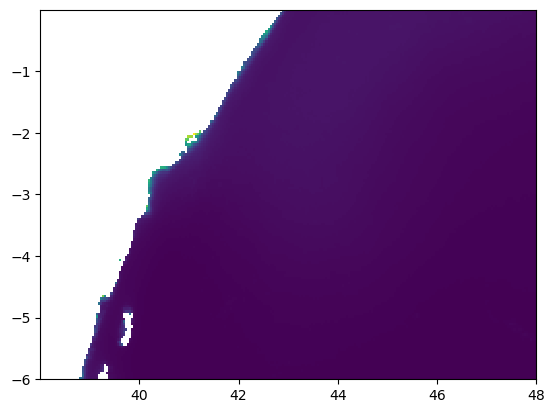

In [34]:
plt.pcolormesh(nem_composite.longitude, nem_composite.latitude, nem_composite['CHL'].data)

In [35]:
nem_ts = get_szn_timeseries(filtered_data=nem, dimensions=['latitude', 'longitude'])['CHL']

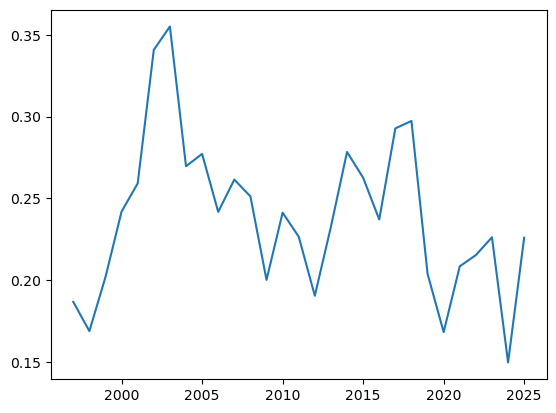

In [37]:
plt.plot(nem_ts.year, nem_ts.data)